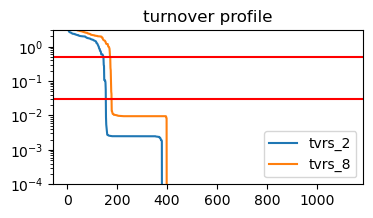

In [69]:
from glob import glob
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
files = glob(f"./pnls/*")

trv_rng=(0.03, 0.5)

tvrs_2=[]
tvrs_8=[]
for f in files:
    try:
        tvr = pd.read_pickle(f)["stat_decay"]["turnover_series"]
        tvrs_2.append(np.quantile(tvr,0.2))
        tvrs_8.append(np.quantile(tvr,0.8))
    except:
        print(f)
pd.DataFrame({
    "tvrs_2": sorted(tvrs_2), "tvrs_8": sorted(tvrs_8)
}).iloc[::-1].reset_index(drop=True).plot(logx=False,logy=True,ylim=(1e-4, 3), title="turnover profile", figsize=(4,2))
plt.axhline(y=trv_rng[0], color="red")
plt.axhline(y=trv_rng[1], color="red")

In [70]:
dfs = [] 
for f in files:
    try:
        df = pd.read_pickle(f)
        # Error filter
        if df["stat"]["returns"] == 0:
            continue
        # Minimal robustness filter
        sharpes = pd.Series({y:df[y]["sharpe"] for y in ["stat","stat_delay","stat_decay"]})
        if (sharpes.max() - sharpes.min())/(sharpes.abs().sum()) > 0.5:
            continue
        # Low turnover filter (overfit risk)
        if np.quantile(df["stat_decay"]["turnover_series"],0.8) < trv_rng[0]:
            continue
        # High turnover filter (tcost)
        if np.quantile(df["stat_decay"]["turnover_series"],0.2) > trv_rng[1]: # 0.10:
            continue
        dfs.append(df)
    except:
        print(f)

print(f"{len(dfs)}/{len(files)} Selected")

26/1131 Selected


<Axes: title={'center': 'weight profile'}>

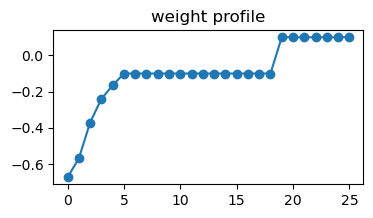

In [74]:
sharpe_threshold = 0.03
# Allows negative weight
weight_function = lambda df: \
    np.clip(np.abs(df["stat_decay"]["sharpe"])-sharpe_threshold,0,0.03) * np.sign(df["stat_decay"]["sharpe"]) \
        / np.clip(np.mean(df["stat_decay"]["turnover_series"]), trv_rng[0], 0.3)

# Weight assignment is skewed towards low turnover
pd.Series([weight_function(df) for df in dfs]).sort_values().reset_index(drop=True).plot(title="weight profile", marker="o", figsize=(4,2))

<Axes: >

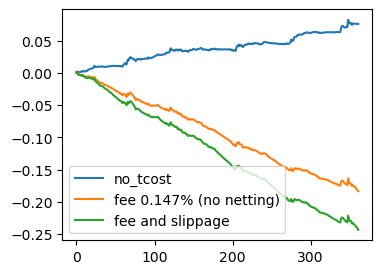

In [76]:
df_ret = pd.DataFrame({
    df["path"]: df["stat_decay"]["returns_series"] * weight_function(df) for df in dfs
}) / np.nansum([np.abs(weight_function(df)) for df in dfs])

df_fee = 1.47 * pd.DataFrame({
    df["path"]: df["stat_decay"]["fee_series"] * abs(weight_function(df)) for df in dfs
}) / np.nansum([np.abs(weight_function(df)) for df in dfs])

df_slippage = pd.DataFrame({
    df["path"]: np.abs(df["stat_decay"]["slippage_series"] * abs(weight_function(df))) for df in dfs
}) / np.nansum([np.abs(weight_function(df)) for df in dfs])

gap = 0.1 # daily gap skip
pd.DataFrame({
    "no_tcost": df_ret.sum(axis=1).clip(-gap,gap).cumsum(),
    "fee 0.147% (no netting)": (df_ret.sum(axis=1) - df_fee.sum(axis=1) ).clip(-gap,gap).cumsum(),
    # "fee 0.147%": (df_ret.sum(axis=1) - df_fee.max(axis=1) ).clip(-gap,gap).cumsum(),
    "fee and slippage":(df_ret.sum(axis=1) - df_fee.sum(axis=1) -df_slippage.sum(axis=1) ).clip(-gap,gap).cumsum(),
    # "fee and slippage":(df_ret.sum(axis=1) - df_fee.max(axis=1) -df_slippage.max(axis=1) ).clip(-gap,gap).cumsum(),
}).reset_index(drop=True).plot(figsize=(4,3))

Text(0.5, 1.0, 'Covariance')

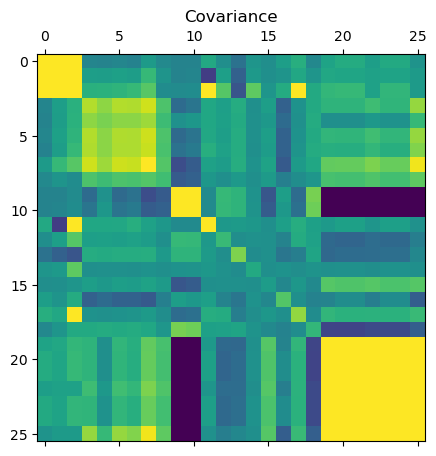

In [77]:
# About 40% of the selected alpha are duplicates
# TODO: Combination better than affine

from scipy.cluster.vq import kmeans, vq
df_r = pd.DataFrame([df["stat_decay"]["returns_series"][-100:] for df in dfs])
codebook, distortion = kmeans(df_r.values, k_or_guess=5)
cluster_idx, _ = vq(df_r.values, codebook)
f = plt.figure(figsize=(5, 5))
plt.matshow(df_r.iloc[np.argsort(cluster_idx)].T.cov().clip(-1e-5, 1e-5), fignum=f.number)
plt.title("Covariance")

In [78]:
from butterflow import lex, Parser, TypeChecker, Builder, Runtime
import numpy as np
from glob import glob
import json
from datetime import datetime, timedelta
import pandas as pd
from rhetenor import data
from rhetenor.backtest import s3_to_df, initialize_runtime, compute, Bars, Position, CloseBacktester
from rhetenor.stat import calculate_stat


SILENT = True
TIMEOUT= True
DELAY = 1 # Use T data, Position calculated at T+1
SIM_INTERVAL = timedelta(minutes=10)
s3_cfgs = {"auth_config_path": "../auth/aws_rhetenor.yaml"}
s3 = data.S3KlineWrapper(exchange_code="UN", bucket="rhetenor", **s3_cfgs)
day_start = datetime.combine(datetime.now().date(), datetime.min.time())
# NOTE: timestamp inconsistency around 20260119 ~ 20260126
s3.load(datetime_from=datetime.now()-timedelta(days=10), datetime_to=day_start)

# Initialize runtime
s3_df, s3_dfs = s3_to_df(s3)
runtime = initialize_runtime(dfs=s3_dfs, add_logret=True)
bars = Bars(data=s3_df, interval=SIM_INTERVAL)


S3KlineWrapper loaded 4793 records.


In [79]:
pos_all = [(df["pos_zerofilled"].data, weight_function(df)) for df in dfs]
pos_all = [pos.div(pos.abs().sum(axis=1), axis=0).fillna(0)*weight for (pos, weight) in pos_all]
pos_all = sum(pos_all)
pos = pos_all.div(pos_all.abs().sum(axis=1), axis=0)

# pos = pos.rolling(20, min_periods=1).mean()
pos = pos.ewm(halflife=100, min_periods=1).mean()
backtester = CloseBacktester(data=bars, fee=0.14 * 0.01)
position = Position(pos, df["pos_zerofilled"].interval)
df_results, pos_nanfilled, pos_zerofilled, pos_actual = backtester.run(position)
stat = calculate_stat(df_results, pos_nanfilled.data, pos_actual.data)
df_stat = pd.DataFrame([stat[x] for x in ["returns_series",'fee_series', 'slippage_series', 'turnover_series']]).T

/home/jongkook90/community_financial_text/ui/rhetenor/notebooks/rhetenor/backtest.py:168: RuntimeWarning: Mean of empty slice
  np.nanmean(x_position, axis=1, keepdims=True)


<Axes: >

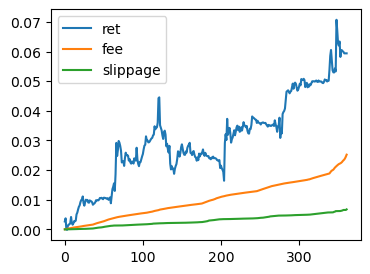

In [80]:
df_stat.iloc[:,:3].cumsum().reset_index(drop=True).plot(figsize=(4,3))

<Axes: >

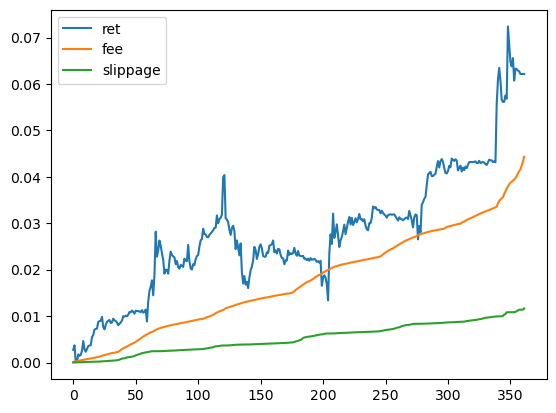

In [9]:
df_stat.iloc[:,:3].cumsum().reset_index(drop=True).plot()

In [1]:
# pd.Series([df["input_code"] for df in dfs]).to_csv("temp.csv")

from rhetenor.data import download_master
a = download_master()

/nix/store/ijcmgn92i7q128lir59icyrj8xrgjgn5-python3-3.13.9-env/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'new.real.download.dws.co.kr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [4]:
# pd.DataFrame(a).T.iloc[0].to_dict()
#  'low_liquidity': 'N',
#  'governance_index_stock': 'N',
#  'kospi200_sector_industry': '',
#  'kospi100': '0',
#  'kospi50': 'N',
#  'krx': 'N',
#  'etp': 'N',
#  'elw_issuance': '',
import pandas as pd 
df = pd.DataFrame(a).T
df.query("kospi50 == 'Y'")
# df["elw_issuance"].unique()

,standard_code,korean_name,market,group_code,market_cap_scale,industry_large,industry_medium,industry_small,manufacturing,low_liquidity,...,operating_profit,ordinary_profit,net_income,roe,base_year_month,market_cap,group_company_code,company_credit_limit_exceed,collateral_loan_available,securities_lending_available
000270,KR7000270009,기아,kospi,ST,1,0027,0015,0000,,N,...,000072356,000081304,60833,000014.10,20250930,000599283,BH1,N,N,Y
000660,KR7000660001,SK하이닉스,kospi,ST,1,0027,0013,0000,,N,...,000280367,000328122,27701,000043.20,20250930,005824018,535,N,N,Y
000810,KR7000810002,삼성화재,kospi,ST,1,0021,0025,0000,,N,...,000022679,000023725,17859,000011.44,20250930,000230975,511,N,N,N
003550,KR7003550001,LG,kospi,ST,1,0021,0000,0000,,N,...,000013339,000013729,12261,000002.61,20250930,000140495,282,N,N,Y
003670,KR7003670007,포스코퓨처엠,kospi,ST,1,0027,0013,0000,,N,...,000000724,000000742,00598,-00006.60,20250930,000204131,853,N,N,Y
005380,KR7005380001,현대차,kospi,ST,1,0027,0015,0000,,N,...,000097725,000121759,91807,000009.96,20250930,001000241,BH1,N,N,Y
005490,KR7005490008,POSCO홀딩스,kospi,ST,1,0027,0011,0000,,N,...,000018144,000012555,08150,000000.82,20250930,000290953,853,N,N,Y
005930,KR7005930003,삼성전자,kospi,ST,1,0027,0013,0000,,N,...,000235274,000284533,25565,000008.37,20250930,009441822,511,N,N,Y
006400,KR7006400006,삼성SDI,kospi,ST,1,0027,0013,0000,,N,...,-00016185,-00011276,-3770,-00002.69,20250930,000312268,511,N,N,Y
009150,KR7009150004,삼성전기,kospi,ST,1,0027,0013,0000,,N,...,000006738,000006269,05037,000007.89,20250930,000206901,511,N,N,Y
